# Objetivo: Regressão no dataset "Real estate valuation" (UCI), usando MLP.
    - Avaliação por validação cruzada k-fold e análise de resíduos.


In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models import reg_mlp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer


2025-08-21 17:49:02.254 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada


In [2]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()
y = real_estate_valuation.data.targets.to_numpy().ravel()


### Random Search (com normalizações) e avaliação final em hold-out
# -------------------------------
# Hold-out: treino/teste (fixo)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)


# K-fold APENAS no treino (k=5)
k_fold_train = aux.validacao_cruzada_kfold(X_train, y_train, k=5)

## Random Search.

In [3]:

# Espaço de busca
hidden_units = [4, 8, 16, 32, 64, 128, 256, 512]
activations = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
epochs_list = [100, 200, 300]
learning_rates = [1e-3, 5e-3, 1e-2]
norm_options = ['zscore', 'minmax', 'iqr']  # NOVO

#### Função auxiliar para treino e validação cruzada com MLP

In [4]:


def make_scaler(name: str, n_samples: int):
    if name == 'none':
        class _NoOp:
            def fit(self, X): return self

            def transform(self, X): return X

            def fit_transform(self, X): return X

        return _NoOp()
    if name == 'zscore':
        return StandardScaler()
    if name == 'minmax':
        return MinMaxScaler()
    if name == 'iqr':
        return QuantileTransformer(
            n_quantiles=min(n_samples, 1000),
            output_distribution='uniform',
            random_state=42
        )
    raise ValueError(f"Normalização desconhecida: {name}")


def cross_val_mlp(X_in, y_in, kfold, layer_sizes, activation, epochs, lr, norm_name):
    """
    CV no TREINO para MLP (saída linear).
    - Normaliza X conforme `norm_name`
    - Normaliza y (StandardScaler) por fold
    Retorna um dicionário com médias de R², RMSE, Hit@10, Hit@20 e o histórico de loss.
    Se qualquer fold estourar (NaN/Inf), marca valid=False e não usa a combinação.
    """
    fold_r2, fold_rmse, fold_h10, fold_h20 = [], [], [], []
    fold_losses = []
    valid = True

    for tr_idx, va_idx in kfold:
        X_tr, X_va = X_in[tr_idx], X_in[va_idx]
        y_tr, y_va = y_in[tr_idx].reshape(-1, 1), y_in[va_idx].reshape(-1, 1)

        # --- X scaler por fold
        scaler_X = make_scaler(norm_name, X_tr.shape[0])
        X_tr_n = scaler_X.fit_transform(X_tr)
        X_va_n = scaler_X.transform(X_va)

        # --- y scaler por fold (crucial p/ estabilidade)
        from sklearn.preprocessing import StandardScaler
        scaler_y = StandardScaler()
        y_tr_s = scaler_y.fit_transform(y_tr)

        # --- treino
        W, loss_hist = reg_mlp.train_mlp_regression(
            X_tr_n, y_tr_s,
            layer_sizes=layer_sizes,
            epochs=epochs,
            eta_i=lr, eta_f=lr,
            hidden_activation=activation,
            output_activation='linear',
            verbose=False
        )
        fold_losses.append(loss_hist)

        # --- predição em validação (reverte escala de y)
        y_va_pred_s = reg_mlp.predict_mlp_regression(
            X_va_n, W, activation, 'linear'
        ).reshape(-1, 1)
        y_va_pred = scaler_y.inverse_transform(y_va_pred_s).flatten()

        # --- métricas no domínio original de y
        eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(
            y_va.flatten(), y_va_pred, aux
        )

        # sanear métricas
        metrics = [eqm, reqm, r2, hit20, hit10]
        if not all(np.isfinite(m) for m in metrics):
            valid = False
            break

        fold_r2.append(float(r2))
        fold_rmse.append(float(reqm))
        fold_h10.append(float(hit10))
        fold_h20.append(float(hit20))

    if not valid or len(fold_r2) == 0:
        return {
            "valid": False,
            "r2_mean": np.nan, "rmse_mean": np.nan,
            "hit10_mean": np.nan, "hit20_mean": np.nan,
            "losses": fold_losses
        }

    return {
        "valid": True,
        "r2_mean": float(np.mean(fold_r2)),
        "rmse_mean": float(np.mean(fold_rmse)),
        "hit10_mean": float(np.mean(fold_h10)),
        "hit20_mean": float(np.mean(fold_h20)),
        "losses": fold_losses
    }



def random_search_with_norm(
    X_in, y_in, kfold,
    hidden_units, activations, epochs_list, lrs, norm_options,
    n_iter=60, seed=42
):
    """
    Random Search incluindo normalização.
    Seleção multi-critério: Hit@10 desc, Hit@20 desc, R² desc, RMSE asc.
    Progresso mostra R², Hit@10 e Hit@20.
    Combinações numéricamente instáveis são ignoradas (não travam o loop).
    """
    import itertools, random, time
    random.seed(seed); np.random.seed(seed)

    all_combos = list(itertools.product(norm_options, activations, hidden_units, epochs_list, lrs))
    sampled = random.sample(all_combos, min(n_iter, len(all_combos)))
    total = len(sampled)

    def key_tuple(d):
        # retorna tupla ordenável (substitui NaN por -inf/+inf apropriadamente)
        def s(x, neg=False):
            if x is None or not np.isfinite(x):
                return -np.inf if not neg else +np.inf
            return -x if neg else x
        # Queremos: Hit@10 (desc), Hit@20 (desc), R² (desc), RMSE (asc)
        return (s(d["hit10_mean"]), s(d["hit20_mean"]), s(d["r2_mean"]), s(d["rmse_mean"], neg=True))

    results = []
    best_cfg = None
    t0 = time.time()

    for i, (norm_name, act, hu, ep, lr) in enumerate(sampled, start=1):
        # (Opcional) heurística para evitar combinações muito agressivas:
        ls = [X_in.shape[1], hu, 1]  # 1 oculta
        cv = cross_val_mlp(X_in, y_in, kfold, ls, act, ep, lr, norm_name)

        if not cv["valid"]:
            msg = "INVALID"
            h10 = h20 = r2m = rmsem = np.nan
        else:
            h10, h20, r2m, rmsem = cv["hit10_mean"], cv["hit20_mean"], cv["r2_mean"], cv["rmse_mean"]
            msg = f"R²cv={r2m:.4f} | Hit@10={h10:.4f} | Hit@20={h20:.4f}"

        cand = {
            "norm": norm_name, "activation": act, "hu": hu,
            "epochs": ep, "lr": lr,
            "hit10_mean": h10, "hit20_mean": h20,
            "r2_mean": r2m, "rmse_mean": rmsem,
            "layer_sizes": ls
        }
        results.append(cand)

        if cv["valid"]:
            if best_cfg is None or key_tuple(cand) > key_tuple(best_cfg):
                best_cfg = cand

        elapsed = time.time() - t0
        if best_cfg is None:
            best_info = "best=N/D"
        else:
            best_info = (f"best: Hit@10={best_cfg['hit10_mean']:.4f}, "
                         f"Hit@20={best_cfg['hit20_mean']:.4f}, R²={best_cfg['r2_mean']:.4f}, "
                         f"RMSE={best_cfg['rmse_mean']:.4f} "
                         f"({best_cfg['norm']},{best_cfg['activation']},HU={best_cfg['hu']})")
        print(f"[{i}/{total}] norm={norm_name:<6} act={act:<10} HU={hu:>3} Ep={ep:>3} LR={lr:<.3g} "
              f"→ {msg} | {best_info} | {elapsed:.1f}s")

    # ranking final
    results_valid = [r for r in results if np.isfinite(r["r2_mean"])]
    results_sorted = sorted(results_valid, key=key_tuple, reverse=True)

    if best_cfg is None:
        raise RuntimeError("Nenhuma combinação válida (todas instáveis). Reduza LR/rede ou normalize y.")

    print("\n=== TOP-10 (CV no TREINO) ===")
    for row in results_sorted[:10]:
        print(f"{row['norm']:>6} | {row['activation']:<10} | HU={row['hu']:>3} | Ep={row['epochs']:>3} | "
              f"LR={row['lr']:<.3g} | R²={row['r2_mean']:.4f} | "
              f"Hit@10={row['hit10_mean']:.4f} | Hit@20={row['hit20_mean']:.4f}")

    print("\n=== Melhor configuração (CV no TREINO) — priorizando Hit@10>Hit@20>R²>RMSE ===")
    print(best_cfg)
    return best_cfg, results_sorted


### Executa Random Search no TREINO

In [5]:
# -------------------------------
# Executa Random Search no TREINO
# -------------------------------
best_cfg, cv_rank = random_search_with_norm(
    X_train, y_train, k_fold_train,
    hidden_units, activations, epochs_list, learning_rates, norm_options,
    n_iter=50, seed=19
)

[1/50] norm=iqr    act=tanh       HU=128 Ep=100 LR=0.001 → R²cv=0.6673 | Hit@10=0.4376 | Hit@20=0.7836 | best: Hit@10=0.4376, Hit@20=0.7836, R²=0.6673, RMSE=8.0267 (iqr,tanh,HU=128) | 7.2s
[2/50] norm=zscore act=sigmoid    HU= 64 Ep=300 LR=0.01 → R²cv=0.5653 | Hit@10=0.4048 | Hit@20=0.6763 | best: Hit@10=0.4376, Hit@20=0.7836, R²=0.6673, RMSE=8.0267 (iqr,tanh,HU=128) | 32.9s
[3/50] norm=iqr    act=leaky_relu HU=  8 Ep=100 LR=0.01 → R²cv=0.6080 | Hit@10=0.4295 | Hit@20=0.7291 | best: Hit@10=0.4376, Hit@20=0.7836, R²=0.6673, RMSE=8.0267 (iqr,tanh,HU=128) | 41.3s
[4/50] norm=minmax act=leaky_relu HU= 32 Ep=100 LR=0.005 → R²cv=0.6467 | Hit@10=0.4333 | Hit@20=0.7215 | best: Hit@10=0.4376, Hit@20=0.7836, R²=0.6673, RMSE=8.0267 (iqr,tanh,HU=128) | 50.1s
[5/50] norm=zscore act=tanh       HU=128 Ep=300 LR=0.001 → R²cv=0.6398 | Hit@10=0.4482 | Hit@20=0.7435 | best: Hit@10=0.4482, Hit@20=0.7435, R²=0.6398, RMSE=8.3350 (zscore,tanh,HU=128) | 72.4s
[6/50] norm=minmax act=leaky_relu HU= 16 Ep=100 LR

## Análise dos resultados do Random Search


=== DESEMPENHO NO TESTE (HOLD-OUT) ===
R² = 0.6349 | RMSE = 7.6523 | EQM = 58.5573 | Hit@10 = 0.4672 | Hit@20 = 0.7810
--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.9113 ± 0.0000
Correlação Média (Teste): 0.8181 ± 0.0000
Coeficiente de Determinação (R²): 0.6349 ± 0.0000

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.7447, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.9313, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


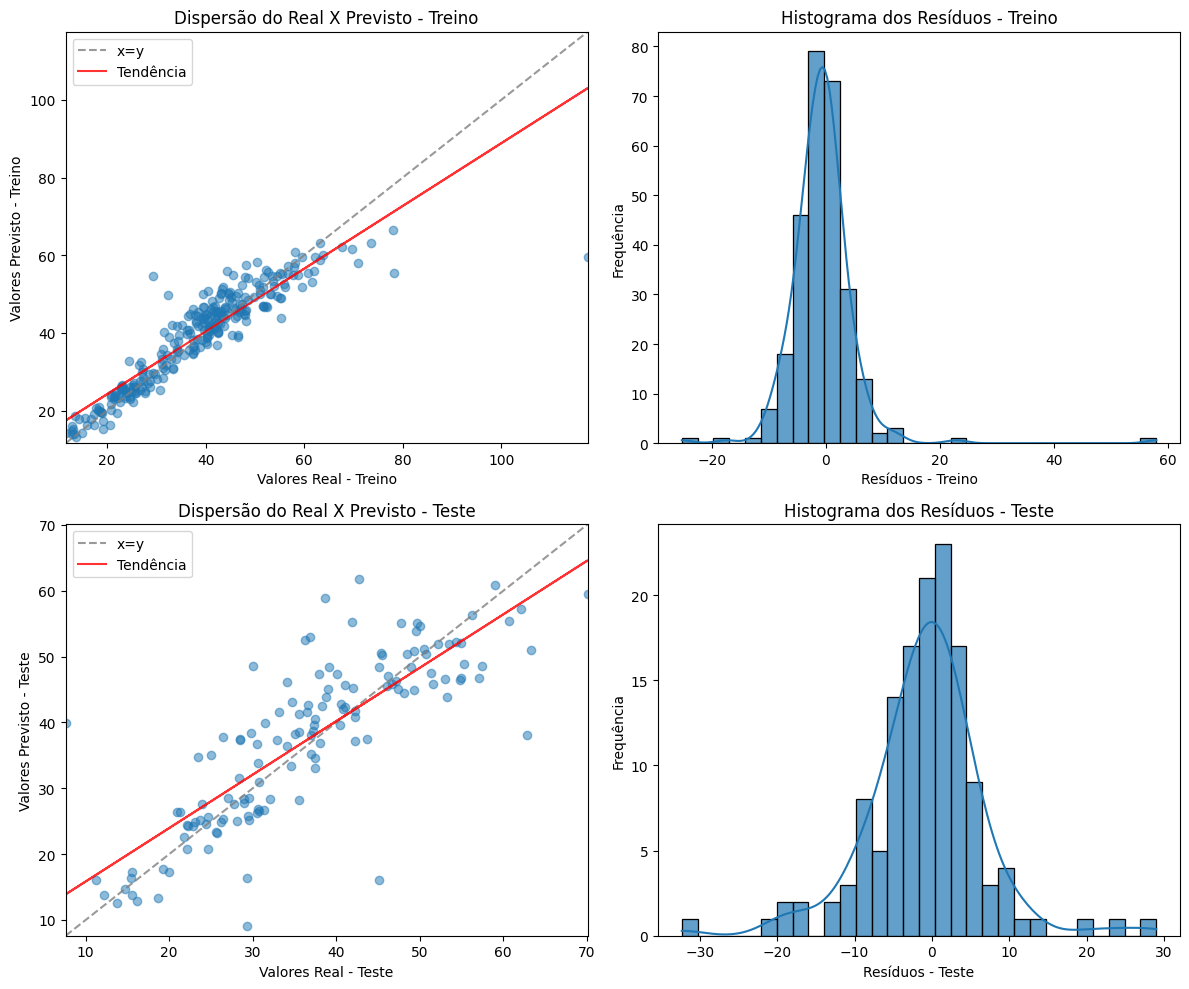

Avg. house price: 37.5022 ± 12.5634
RSME/Avg. house price: 0.1605 ± 0.2611


/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/aux.py:334: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


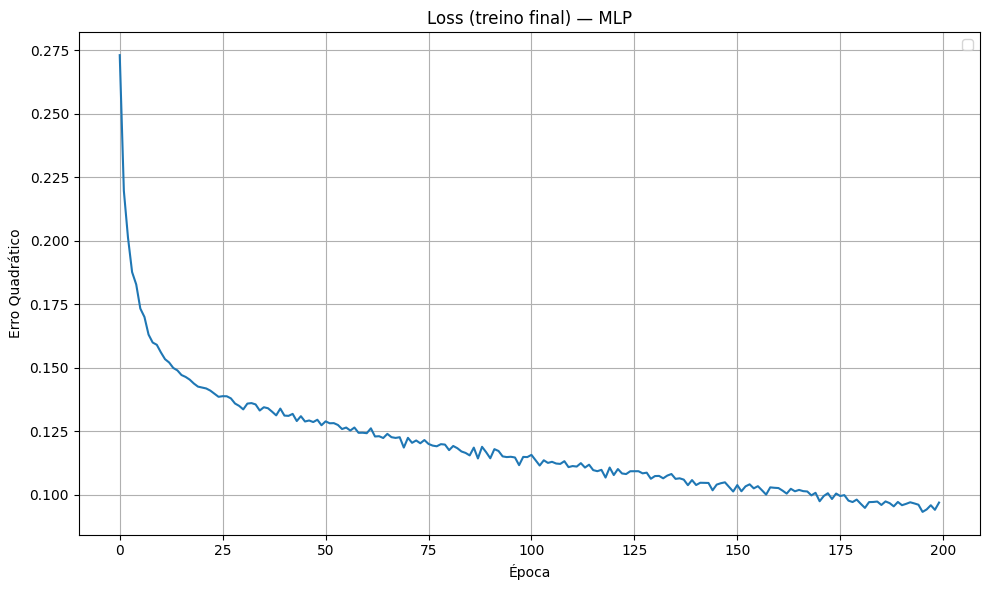

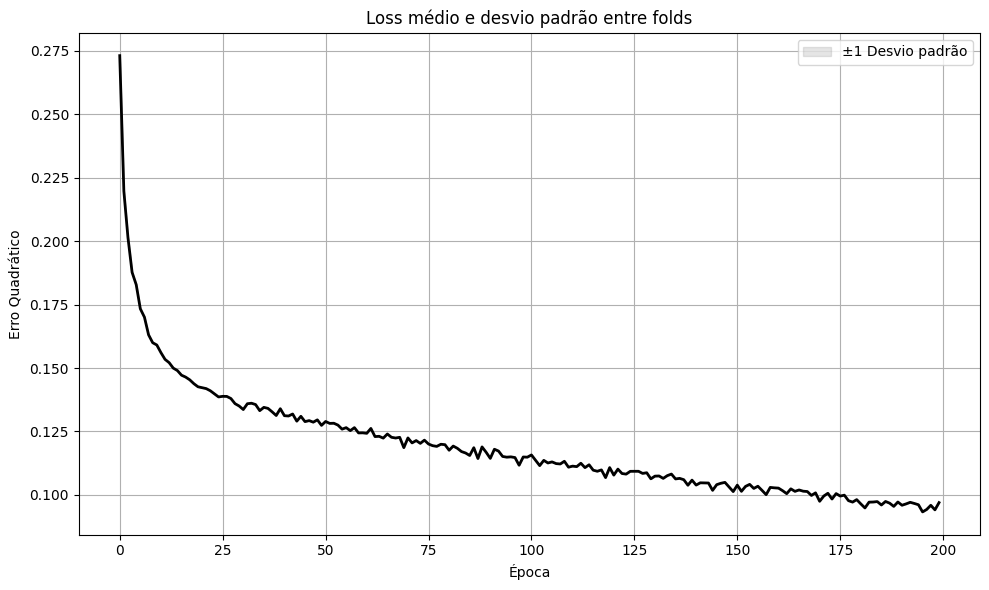

In [6]:

# -------------------------------
# Reajuste no TREINO COMPLETO e avaliação no TESTE (hold-out)
# -------------------------------
norm_best = best_cfg['norm']
act_best  = best_cfg['activation']
ls_best   = best_cfg['layer_sizes']
ep_best   = best_cfg['epochs']
lr_best   = best_cfg['lr']

# Scaler de X final
scaler_X_final = make_scaler(norm_best, X_train.shape[0])
X_train_n = scaler_X_final.fit_transform(X_train)
X_test_n  = scaler_X_final.transform(X_test)

# Scaler de y final
from sklearn.preprocessing import StandardScaler
scaler_y_final = StandardScaler()
y_train_s = scaler_y_final.fit_transform(y_train.reshape(-1, 1))

# Treino final
W_best, loss_hist_best = reg_mlp.train_mlp_regression(
    X_train_n, y_train_s,
    layer_sizes=ls_best,
    epochs=ep_best,
    eta_i=lr_best, eta_f=lr_best,
    hidden_activation=act_best,
    output_activation='linear',
    verbose=False
)

# Predições (desfaz escala de y)
y_train_pred_s = reg_mlp.predict_mlp_regression(X_train_n, W_best, act_best, 'linear').reshape(-1, 1)
y_test_pred_s  = reg_mlp.predict_mlp_regression(X_test_n,  W_best, act_best, 'linear').reshape(-1, 1)
y_train_pred = scaler_y_final.inverse_transform(y_train_pred_s).flatten()
y_test_pred  = scaler_y_final.inverse_transform(y_test_pred_s).flatten()

# Métricas no hold-out
eqm_t, rmse_t, r2_t, hit20_t, hit10_t, _ = aux.calcular_metricas(y_test, y_test_pred, aux)
print("\n=== DESEMPENHO NO TESTE (HOLD-OUT) ===")
print(f"R² = {r2_t:.4f} | RMSE = {rmse_t:.4f} | EQM = {eqm_t:.4f} | "
      f"Hit@10 = {hit10_t:.4f} | Hit@20 = {hit20_t:.4f}")

# Resíduos (hold-out)
corr_tr = np.corrcoef(y_train, y_train_pred)[0, 1]
corr_te = np.corrcoef(y_test,  y_test_pred)[0, 1]
aux.imprimir_correlacoes([corr_tr], [corr_te], [r2_t])

aux.analisar_residuos(
    y_train, y_train_pred,
    y_test,  y_test_pred,
    aux,
    titulo=f"MLP (linear) — hold-out (norm={norm_best}, act={act_best}, HU={ls_best[1]})"
)
aux.calcular_metricas_normalizadas(y_test_pred, y_test)

aux.plot_folds_loss([loss_hist_best],
                    titulo="Loss (treino final) — MLP",
                    ylabel="Erro Quadrático",
                    xlabel="Época")
